<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜:
* 이름:

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts')
from lib import *

In [3]:
'''lib.py
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
'''

'lib.py\nimport tensorflow as tf\nfrom tensorflow.keras import models, layers, utils, losses, optimizers\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport seaborn as sns\n'

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/kaggle.json
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#! chmod 600 /content/drive/MyDrive/scripts/kaggle.json

In [6]:
! mkdir ~/.kaggle/

In [7]:
! cp /content/drive/MyDrive/scripts/kaggle.json ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:19<00:00, 75.7MB/s]
100% 1.21G/1.21G [00:19<00:00, 67.6MB/s]


In [9]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

### **| EDA**

In [10]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


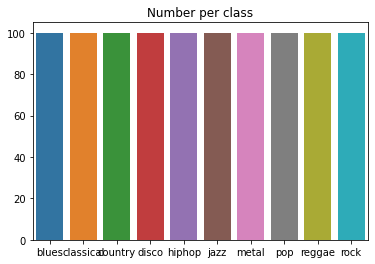

In [11]:
# 예측해야할 클래스
class_count = df['label'].value_counts()
plt.title('Number per class')
_=sns.barplot(x=class_count.index , y=class_count.values)

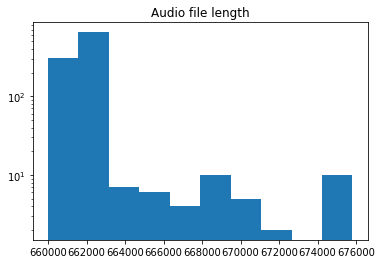

In [12]:
# 음성 파일의 길이
plt.title('Audio file length')
_=plt.hist(df['length'], log=True)

특성 개수 57


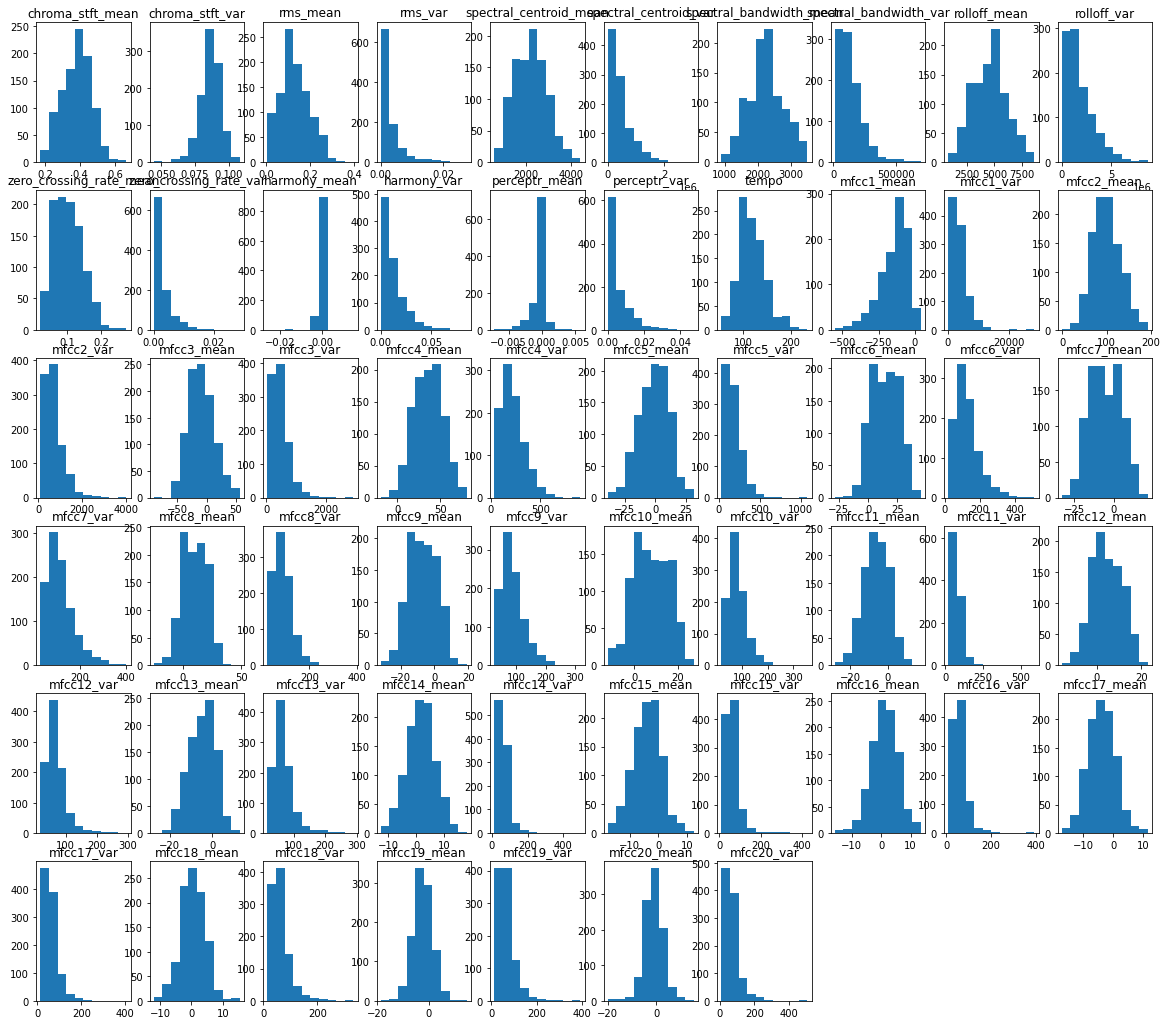

In [13]:
# 특성 분포 
print('특성 개수', len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]):
  plt.subplot(6,10, i+1)
  plt.title(col)
  plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


In [ ]:
df.

In [50]:
import librosa

new_arr = np.zeros([1000, 8])
for i, (f_name, label) in enumerate(zip(df['filename'], df['label'])):
  if i%10==0: print(f'* {i}')
  if f_name =='jazz.00054.wav': continue
  dir_path =  f'/content/Data/genres_original/{label}'
  f_path = f'{dir_path}/{f_name}'
  # file path로부터 wav 데이터 읽기
  y, sr = librosa.load(f_path) #y: 데이터(1차원 배열)  sr: sampling rate
  # print(f_path, y.shape)
  # 읽어낸 데이에서 feautre를 추출
  chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
  spectral_flatness = librosa.feature.spectral_flatness(y=y)
  tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

  chroma_cens_mean = np.mean(chroma_cens)
  chroma_cens_var = np.var(chroma_cens)
  spectral_contrast_mean = np.mean(spectral_contrast)
  spectral_contrast_var = np.var(spectral_contrast)
  spectral_flatness_mean = np.mean(spectral_flatness)
  spectral_flatness_var = np.var(spectral_flatness)
  tonnetz_mean = np.mean(tonnetz)
  tonnetz_var = np.var(tonnetz)

  new_arr[i, 0]=chroma_cens_mean
  new_arr[i, 1]=chroma_cens_var
  new_arr[i, 2]=spectral_contrast_mean
  new_arr[i, 3]=spectral_contrast_var
  new_arr[i, 4]=spectral_flatness_mean
  new_arr[i, 5]=spectral_flatness_var
  new_arr[i, 6]=tonnetz_mean
  new_arr[i, 7]=tonnetz_var

new_arr.shape

* 0
* 10
* 20
* 30
* 40
* 50
* 60
* 70
* 80
* 90
* 100
* 110
* 120
* 130
* 140
* 150
* 160
* 170
* 180
* 190
* 200
* 210
* 220
* 230
* 240
* 250
* 260
* 270
* 280
* 290
* 300
* 310
* 320
* 330
* 340
* 350
* 360
* 370
* 380
* 390
* 400
* 410
* 420
* 430
* 440
* 450
* 460
* 470
* 480
* 490
* 500
* 510
* 520
* 530
* 540
* 550
* 560
* 570
* 580
* 590
* 600
* 610
* 620
* 630
* 640
* 650
* 660
* 670
* 680
* 690
* 700
* 710
* 720
* 730
* 740
* 750
* 760
* 770
* 780
* 790
* 800
* 810
* 820
* 830
* 840
* 850
* 860
* 870
* 880
* 890
* 900
* 910
* 920
* 930
* 940
* 950
* 960
* 970
* 980
* 990


(1000, 8)

In [52]:
df.shape, new_arr.shape

((1000, 61), (1000, 8))

In [53]:
df['chroma_cens_mean'] = new_arr[:, 0]
df['chroma_cens_var'] = new_arr[:, 1]
df['spectral_contrast_mean'] = new_arr[:, 2]
df['spectral_contrast_var'] = new_arr[:, 3]
df['spectral_flatness_mean'] = new_arr[:, 4]
df['spectral_flatness_var'] = new_arr[:, 5]
df['tonnetz_mean']= new_arr[:, 6]
df['tonnetz_var']= new_arr[:, 7]

In [56]:
print(df.shape)
df.head()

(1000, 69)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,label,le_label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,blues,0,0.272036,0.009330,20.526699,76.741834,0.004498,0.000030,0.007162,0.004417
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,blues,0,0.260980,0.015223,20.676128,67.851520,0.002298,0.000024,0.029154,0.004762
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,blues,0,0.262627,0.014360,22.197517,76.130717,0.002631,0.000011,0.024264,0.010511
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,blues,0,0.226383,0.032084,21.426268,63.384626,0.000954,0.000003,0.026562,0.017854
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,blues,0,0.259550,0.015967,21.466338,62.986186,0.003238,0.000019,-0.020919,0.010125


In [13]:
# 추가된 데이터 로 전처리 
  # 데이터 하나 빼기 (데이터 프레임에서 한줄만 제거하면 된다. (jazz0054))

# 추가된 데이터 머신러닝 돌리기
  # pycaret

# 추가된 데이터 딥러닝 돌리기

### **| 전처리**


In [57]:
# label encoding ( blues, classical, ... ) - > (0, 1, ...)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,label,le_label,chroma_cens_mean,chroma_cens_var,spectral_contrast_mean,spectral_contrast_var,spectral_flatness_mean,spectral_flatness_var,tonnetz_mean,tonnetz_var
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,blues,0,0.272036,0.009330,20.526699,76.741834,0.004498,0.000030,0.007162,0.004417
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,blues,0,0.260980,0.015223,20.676128,67.851520,0.002298,0.000024,0.029154,0.004762
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,blues,0,0.262627,0.014360,22.197517,76.130717,0.002631,0.000011,0.024264,0.010511
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,blues,0,0.226383,0.032084,21.426268,63.384626,0.000954,0.000003,0.026562,0.017854
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,blues,0,0.259550,0.015967,21.466338,62.986186,0.003238,0.000019,-0.020919,0.010125


In [58]:
x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
y = df['le_label']
x.shape, y.shape

((1000, 65), (1000,))

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (900, 65) (900,)
test (100, 65) (100,)


In [60]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((900, 65), (100, 65))

### **| 학습 - XGBoost**

In [61]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc: 0.83


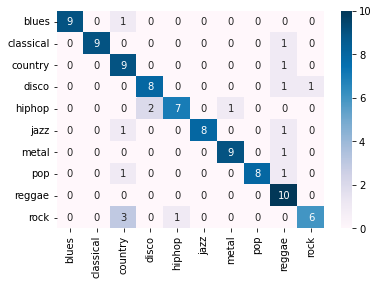

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test, proba=False):
  y_pred = model.predict(x_test)
  if proba: 
    y_pred = np.argmax(y_pred, axis=1)
  print('Test Acc:', accuracy_score(y_test, y_pred))
  #print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  _=sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels=le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)

### **| 학습 - DNN**

In [68]:
# 딥러닝 (Dense layer)
def build_dnn():
  x = layers.Input(shape=(65,))
  y = layers.Dense(1024, activation='relu')(x)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(10, activation='softmax')(y)
  model = models.Model(x, y)
  return model

In [69]:
dnn = build_dnn()
dnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 65)]              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              67584     
                                                                 
 dense_7 (Dense)             (None, 128)               131200    
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 200,074
Trainable params: 200,074
Non-trainable params: 0
_________________________________________________________________


In [70]:
dnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
dnn.fit(x_train, y_train, epochs=15, batch_size=8)

Epoch 1/15
113/113 [==============================] - 1s 2ms/step - loss: 1.2948 - accuracy: 0.5378
Epoch 2/15
113/113 [==============================] - 0s 2ms/step - loss: 0.7282 - accuracy: 0.7444
Epoch 3/15
113/113 [==============================] - 0s 2ms/step - loss: 0.5280 - accuracy: 0.8333
Epoch 4/15
113/113 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.8778
Epoch 5/15
113/113 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.9167
Epoch 6/15
113/113 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.9278
Epoch 7/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9500
Epoch 8/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9600
Epoch 9/15
113/113 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.9778
Epoch 10/15
113/113 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9767

Test Acc: 0.73


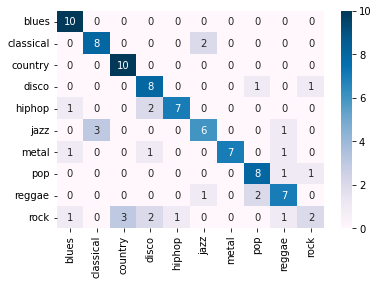

In [72]:
show_result(dnn, x_test, y_test, proba=True)

## 딥러닝 접근 방법(Audio 원 데이터)
---